In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from utils import *

seed = 42

## set up dataset

In [ ]:
set_idx = 4

# load raw data
precursor_info_path = './dataset/precursor_info.tsv'
matrix_path = './dataset/matrix_mz_prob_mean_var.npy'
indices_path = f'./dataset/train_test_split_set_{set_idx}.npy'
predictions_folder = f'./predictions/{set_idx}_'

precursor_df = pd.read_csv(precursor_info_path, sep='\t')
# each row is a precursor, which is a pair of (peptide_sequence, charge)
# columns: [
#   'precursor_index',          # corresponds to the index of the first order of the matrix
#   'sequence',                 # peptide sequence, no modification by now
#   'charge',                   # charge of the precursor
#   'num_PSMs'                  # number of spectra that associated with this precursor
# ]

matrix = np.load(matrix_path)
# matrix is a 3D numpy array with shape (num_precursors, num_tokens_to_predict, 4)
#   num_precursors: the ith precursor corresponds to the ith row in precursor_df
#   num_tokens_to_predict: the number of tokens (peak) to predict in the ith precursor
#   4: for each token, there are 4 values: [
#       "m/z",                  # the m/z value of the token (peak)
#       "probability",          # the probability of the token (peak) to be observed
#       "mean_intensity",       # the mean intensity of the token (peak)
#       "var_intensity"         # the variance of the intensity of the token (peak)



loaded_data = np.load(indices_path, allow_pickle=True).reshape(1)[0]

# loaded_data is a dictionary with the following keys:
#   'train_indices': the indices of the training set
#   'test_indices': the indices of the test set
#   'train_indices' and 'test_indices' are numpy arrays of shape (80% num_samples,) and (20% num_samples,) respectively
train_indices = loaded_data['train_indices']
test_indices = loaded_data['test_indices']

In [26]:
np.concatenate((train_indices, test_indices), axis=0).max()
matrix.shape[0]

# number of rows
print(precursor_df.index.max())
print(precursor_df.shape[0])
print(precursor_df['precursor_index'].max())

610116
610117
610116


In [27]:
# create peak mask: probabilities outside mask shouldn't have value and are set to -1

peak_mask = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=bool)

def get_ion_mask(seq_len, charge, max_seq_len):
    # a2+ ions
    mask = [True]
    if charge > 3:
        charge = 3
    # b/y ions with charge 1/2/3
    for ion in range(1, 3):
        for chr in range(1, 4):
            if chr > charge:
                for seq_idx in range(1, max_seq_len):
                    mask.append(False)
            else:
                for seq_idx in range(1, max_seq_len):
                    if seq_idx < seq_len:
                        mask.append(True)
                    else:
                        mask.append(False)
    return mask

for i in range(matrix.shape[0]):
    seq_len = len(precursor_df['sequence'][i])
    charge = precursor_df['charge'][i]
    max_seq_len = matrix.shape[1]
    mask = get_ion_mask(seq_len, charge, 40)
    peak_mask[i, :] = mask

assert matrix[:, :, 1][~peak_mask].max() < 1e-8


probabilities = matrix[:, :, 1].copy()
probabilities[~peak_mask] = -1

In [28]:
# create filter mask: only precursors satisfying the following conditions are kept
min_num_psms = 30
max_charge = 100
max_seq_length = 100


filtered_indices = precursor_df[
    (precursor_df['num_PSMs'] >= min_num_psms) &
    (precursor_df['charge'] <= max_charge) &
    (precursor_df['sequence'].str.len() <= max_seq_length)
].index

filter_mask = np.zeros((matrix.shape[0],), dtype=bool)
filter_mask[filtered_indices] = True

# filtered_sequences = precursor_df['sequence'].iloc[filtered_indices].values
# filtered_charges = precursor_df['charge'].iloc[filtered_indices].values
# filtered_num_PSMs = precursor_df['num_PSMs'].iloc[filtered_indices].values

# filtered_probabilities = probabilities[filtered_indices]


In [29]:
# encode sequences and charges into integers. 0 is reserved for padding
sequences = precursor_df['sequence'].values
charges = precursor_df['charge'].values
num_PSMs = precursor_df['num_PSMs'].values


unique_chars = set(''.join(sequences))
char_to_int = {char: i+1 for i, char in enumerate(unique_chars)}
# reserve 0 for padding

unique_charges = set(charges)
charge_to_int = {charge: i+1 for i, charge in enumerate(unique_charges)}
# reserve 0 for padding

max_sequence_length = max(len(seq) for seq in sequences)
def encode_sequence_and_charge(seq, charge):
    seq_encoded = np.zeros(max_sequence_length+1, dtype=int)
    seq_encoded[0] = charge_to_int[charge]
    for i, char in enumerate(seq):
        seq_encoded[i+1] = char_to_int[char]
    return seq_encoded



X = np.array([encode_sequence_and_charge(seq, charge) for seq, charge in zip(sequences, charges)])
Y = probabilities


idx = 1234
print(f"Sequence: {sequences[idx]}")
print(f"Charge: {charges[idx]}")
print(f"Encoded Sequence: {X[idx, :]}")
print(f"Probabilities (first 20): {Y[idx, :20]}")

Sequence: AAEAVAAAVGTGATTAAVMAAAGIAAIGPAKELEAER
Charge: 4
Encoded Sequence: [ 4 13 13  3 13 12 13 13 13 12 18  4 18 13  4  4 13 13 12  5 13 13 13 18
 15 13 13 15 18  1 13 14  3 11  3 13  3 16  0  0  0]
Probabilities (first 20): [0.853659 0.       0.853659 0.97561  1.       1.       1.       0.97561
 1.       0.951219 0.878049 0.780488 0.634146 0.658537 0.439024 0.170732
 0.146341 0.512195 0.097561 0.      ]


In [30]:
# create one-hot version of X
X_1hot = np.zeros((X.shape[0], X.shape[1], len(char_to_int)), dtype=int)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if X[i, j] != 0:
            X_1hot[i, j, X[i, j]-1] = 1
X_1hot = X_1hot.reshape(X.shape[0], -1)

idx = 1234
print(f"One-hot Encoded Sequence: {X_1hot[idx, :]}")

One-hot Encoded Sequence: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0

In [31]:
# train test split

train_mask = np.zeros(matrix.shape[0], dtype=bool)
train_mask[train_indices] = True
train_mask = np.logical_and(train_mask, filter_mask)

test_mask = np.zeros(matrix.shape[0], dtype=bool)
test_mask[test_indices] = True
test_mask = np.logical_and(test_mask, filter_mask)

X_train = X_1hot[train_mask]
Y_train = Y[train_mask]
X_test = X_1hot[test_mask]
Y_test = Y[test_mask]

# Y_total = Y
# X_total = X_1hot


## Value statistics predictor
Estimate probability of a peak based on its frequency in the training set.

Two seperate estimators are constructed:
1. estimator A conditions on ion and charge
2. estimator B conditions on ion & charge and pre-(suf-)fix. 

In [32]:
sequences_train = sequences[train_mask]
sequences_test = sequences[test_mask]
charges_train = charges[train_mask]
charges_test = charges[test_mask]
PSMs_train = num_PSMs[train_mask]
PSMs_test = num_PSMs[test_mask]

In [33]:
# construct estimators

# estimator A conditions on ion and charge
estimA = {}
# estimator A conditions on ion and charge and pre/suffix
estimB = {}

for idx, seq in enumerate(sequences_train):
    num_PSMs = PSMs_train[idx]
    for pos in range(Y.shape[1]):

        if Y_train[idx, pos] < -0.1:
            continue

        ion_type, ion_charge, cut_pos = frag_ion_names[pos]
        if ion_type == 'a' or ion_type == 'b':
            pre_suf_fix = seq[:cut_pos]
        else:
            pre_suf_fix = seq[-cut_pos:]
        keyA = (ion_type, ion_charge)
        keyB = (ion_type, ion_charge, pre_suf_fix)
        prob = Y_train[idx, pos]

        if keyA not in estimA:
            estimA[keyA] = (prob*num_PSMs, num_PSMs)
        else:
            estimA[keyA] = (estimA[keyA][0] + prob*num_PSMs, estimA[keyA][1] + num_PSMs)
        
        if keyB not in estimB:
            estimB[keyB] = (prob*num_PSMs, num_PSMs)
        else:
            estimB[keyB] = (estimB[keyB][0] + prob*num_PSMs, estimB[keyB][1] + num_PSMs)

# calculate mean
estimA0 = {x: estimA[x][0]/estimA[x][1] for x in estimA}
estimB0 = {x: estimB[x][0]/estimB[x][1] for x in estimB}


In [34]:
# evaluate estimators on the whole dataset

predA = np.zeros((Y.shape[0], Y.shape[1]))
predB = np.zeros((Y.shape[0], Y.shape[1]))

for idx, seq in enumerate(sequences):
    for pos in range(Y.shape[1]):

        if Y[idx, pos] < -0.1:
            predA[idx, pos] = -1
            predB[idx, pos] = -1
            continue

        ion_type, ion_charge, cut_pos = frag_ion_names[pos]
        if ion_type == 'a' or ion_type == 'b':
            pre_suf_fix = seq[:cut_pos]
        else:
            pre_suf_fix = seq[-cut_pos:]
        keyA = (ion_type, ion_charge)
        keyB = (ion_type, ion_charge, pre_suf_fix)
        if keyA in estimA0:
            predA[idx, pos] = estimA0[keyA]
        if keyB in estimB0:
            predB[idx, pos] = estimB0[keyB]

In [35]:
# save the whole results for later evaluation

np.save(predictions_folder+'estimator_A'+'.npy', predA) 
np.save(predictions_folder+'estimator_B'+'.npy', predB)
# predictions_folder

print("Estimator A predictions saved to: ", predictions_folder+'estimator_A'+'.npy')
print("Estimator B predictions saved to: ", predictions_folder+'estimator_B'+'.npy')

Estimator A predictions saved to:  ./predictions/3_estimator_A.npy
Estimator B predictions saved to:  ./predictions/3_estimator_B.npy


In [36]:
# mean l1 and MSE loss on test set
tmp_mask = (Y_test >= -.1)

lossA = np.abs(predA[test_mask][tmp_mask] - Y_test[tmp_mask]).mean()
lossB = np.abs(predB[test_mask][tmp_mask] - Y_test[tmp_mask]).mean()

mseA = ((predA[test_mask][tmp_mask] - Y_test[tmp_mask])**2).mean()
mseB = ((predB[test_mask][tmp_mask] - Y_test[tmp_mask])**2).mean()


print(f"Mean L1 loss of estimator A: {lossA}")
print(f"Mean L1 loss of estimator B: {lossB}")

print(f"MSE loss of estimator A: {mseA}")
print(f"MSE loss of estimator B: {mseB}")

Mean L1 loss of estimator A: 0.2400692086089979
Mean L1 loss of estimator B: 0.17887376667234345
MSE loss of estimator A: 0.10078319603828337
MSE loss of estimator B: 0.11863857940326544


## Linear regression

For each element in Y, set up an independent linear regressor

In [37]:
from sklearn.linear_model import SGDRegressor

# Initialize a list to store the regressors
regressors = []

# Train a separate regressor for each column in Y
for i in range(Y_train.shape[1]):
    regressor = SGDRegressor(loss='epsilon_insensitive', epsilon=0, random_state=seed)
    regressor.fit(X_train, Y_train[:, i])
    regressors.append(regressor)
    print(f"Regressor {i} trained.")

Regressor 0 trained.
Regressor 1 trained.
Regressor 2 trained.
Regressor 3 trained.
Regressor 4 trained.
Regressor 5 trained.
Regressor 6 trained.
Regressor 7 trained.
Regressor 8 trained.
Regressor 9 trained.
Regressor 10 trained.
Regressor 11 trained.
Regressor 12 trained.
Regressor 13 trained.
Regressor 14 trained.
Regressor 15 trained.
Regressor 16 trained.
Regressor 17 trained.
Regressor 18 trained.
Regressor 19 trained.
Regressor 20 trained.
Regressor 21 trained.
Regressor 22 trained.
Regressor 23 trained.
Regressor 24 trained.
Regressor 25 trained.
Regressor 26 trained.
Regressor 27 trained.
Regressor 28 trained.
Regressor 29 trained.
Regressor 30 trained.
Regressor 31 trained.
Regressor 32 trained.
Regressor 33 trained.
Regressor 34 trained.
Regressor 35 trained.
Regressor 36 trained.
Regressor 37 trained.
Regressor 38 trained.
Regressor 39 trained.
Regressor 40 trained.
Regressor 41 trained.
Regressor 42 trained.
Regressor 43 trained.
Regressor 44 trained.
Regressor 45 trained

In [38]:
# predict on the whole dataset
linear_pred = np.zeros((Y.shape[0], Y.shape[1]))
for i in range(Y.shape[1]):
    linear_pred[:, i] = regressors[i].predict(X_1hot)

# save the whole results for later evaluation
np.save(predictions_folder+'linear_regression'+'.npy', linear_pred)
print("Linear regression predictions saved to: ", predictions_folder+'linear_regression'+'.npy')

Linear regression predictions saved to:  ./predictions/3_linear_regression.npy


In [39]:
# compute l1 and MSE loss on test set
tmp_mask = (Y_test >= -.1)
l1_linear = np.abs(linear_pred[test_mask][tmp_mask] - Y_test[tmp_mask]).mean()
mse_linear = ((linear_pred[test_mask][tmp_mask] - Y_test[tmp_mask])**2).mean()

print(f"Mean L1 loss of linear regression: {l1_linear}")
print(f"MSE loss of linear regression: {mse_linear}")

Mean L1 loss of linear regression: 0.1341388241523988
MSE loss of linear regression: 0.05803715006853861


## simple neural-network with skip connection

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# fix random seed for torch
torch.manual_seed(seed)

# Create DataLoader
batch_size = 512

from torch.utils.data import DataLoader, TensorDataset
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(SimpleNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc2(x))/2 + x/2
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc3(x)/2) + x/2
        x = self.fc4(x)
        x = F.sigmoid(x)
        return x

# Initialize the model, and optimizer
input_size = X_train.shape[1]
output_size = Y_train.shape[1]

hidden_size = 512
dropout_rate = 0.15
num_epochs = 200

model = SimpleNN(input_size, hidden_size, output_size, dropout_rate).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()


# training

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        mask = targets > -.1
        loss = loss_fn(outputs[mask], targets[mask])
        # loss = -F.cosine_similarity(outputs, targets).mean()

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        train_loss_list.append(loss.item())
        
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # eval on test set
    model.eval()
    total_loss = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            mask = targets > -.1
            loss = loss_fn(outputs[mask], targets[mask])
            total_loss.append(loss.item())
    total_loss = np.mean(total_loss)
    test_loss_list.append(total_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {total_loss:.4f}")
    


Epoch [1/200], Step [100/554], Loss: 0.1615
Epoch [1/200], Step [200/554], Loss: 0.1463
Epoch [1/200], Step [300/554], Loss: 0.1446
Epoch [1/200], Step [400/554], Loss: 0.1267
Epoch [1/200], Step [500/554], Loss: 0.1213
Epoch [1/200], Test Loss: 0.1148
Epoch [2/200], Step [100/554], Loss: 0.1126
Epoch [2/200], Step [200/554], Loss: 0.1089
Epoch [2/200], Step [300/554], Loss: 0.1061
Epoch [2/200], Step [400/554], Loss: 0.1061
Epoch [2/200], Step [500/554], Loss: 0.1028
Epoch [2/200], Test Loss: 0.1017
Epoch [3/200], Step [100/554], Loss: 0.1008
Epoch [3/200], Step [200/554], Loss: 0.0991
Epoch [3/200], Step [300/554], Loss: 0.0990
Epoch [3/200], Step [400/554], Loss: 0.0997
Epoch [3/200], Step [500/554], Loss: 0.0977
Epoch [3/200], Test Loss: 0.0967
Epoch [4/200], Step [100/554], Loss: 0.0968
Epoch [4/200], Step [200/554], Loss: 0.0945
Epoch [4/200], Step [300/554], Loss: 0.0964
Epoch [4/200], Step [400/554], Loss: 0.0968
Epoch [4/200], Step [500/554], Loss: 0.0960
Epoch [4/200], Test L

Train loss saved to:  ./predictions/3_nn_train_loss.npy
Test loss saved to:  ./predictions/3_nn_test_loss.npy


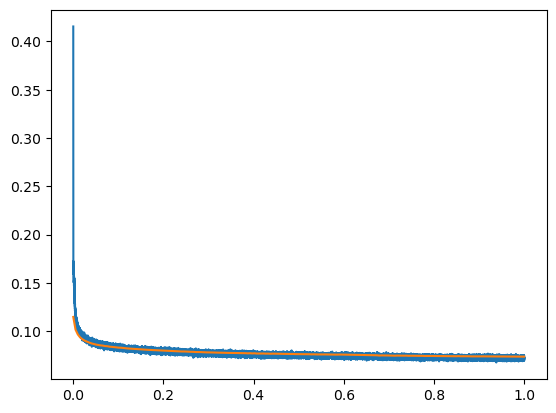

In [42]:
x = np.arange(len(train_loss_list)) / (len(train_loss_list)-1)
plt.plot(x, train_loss_list)

x = np.arange(len(test_loss_list)) / (len(test_loss_list)-1)
plt.plot(x, test_loss_list)

# save train and test loss
np.save(predictions_folder+'nn_train_loss.npy', np.array(train_loss_list))
np.save(predictions_folder+'nn_test_loss.npy', np.array(test_loss_list))
print("Train loss saved to: ", predictions_folder+'nn_train_loss.npy') 
print("Test loss saved to: ", predictions_folder+'nn_test_loss.npy')

In [43]:
# predict on the whole dataset
Y_pred = np.zeros((X.shape[0], Y.shape[1]))
model.eval()
with torch.no_grad():
    for i in range(0, X.shape[0], batch_size):
        inputs = X_1hot[i:i+batch_size]
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        outputs = model(inputs)
        Y_pred[i:i+batch_size] = outputs.cpu().numpy()

# save the whole results for later evaluation
np.save(predictions_folder+'nn'+'.npy', Y_pred)
print("NN predictions saved to: ", predictions_folder+'nn'+'.npy')

NN predictions saved to:  ./predictions/3_nn.npy


In [44]:
# compute l1 and MSE loss on test set
tmp_mask = (Y_test >= -.1)
l1_nn = np.abs(Y_pred[test_mask][tmp_mask] - Y_test[tmp_mask]).mean()
mse_nn = ((Y_pred[test_mask][tmp_mask] - Y_test[tmp_mask])**2).mean()
print(f"Mean L1 loss of NN: {l1_nn}")
print(f"MSE loss of NN: {mse_nn}")

Mean L1 loss of NN: 0.07397113796379781
MSE loss of NN: 0.023918012985044233
